# Описание проекта

* **Сфера деятельности**: сервис по продаже автомобилей с пробегом

* **Цель**: построить модель определения рыночной стоимости автомобиля по технических характеристикам, комплектации и ценах других автомобилей.

* **Ключевые критерии качества модели** (в порядке приоритетности):
    - качество предсказания (**метрика RMSE < 2500**)
    - время обучения модели
    - время предсказания модели

* **Задачи**:
    - Загрузить данные и описать данные;
    - Осуществить предобработку;
    - Подготовить выборки для обучения моделей;
    - Обучить разные модели, одна из которых — **LightGBM**, как минимум **одна — не бустинг**. Для каждой модели необходимо попробовать разные гиперпараметры.
    - Проанализировать время обучения, время предсказания и качество моделей;
    - Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## Описание данных:
* **Признаки**:
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - NotRepaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
* **Целевой признак**:
    - Price — цена (евро)

In [17]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import statistics

import time

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline


from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Загрузка и подготовка данных к анализу

### 1.1 Загрузка  данных

In [18]:
# Загрузка данных
try:
    try:
        df = pd.read_csv('autos.csv')
    except:
        df = pd.read_csv('/datasets/autos.csv')

    print('Вывод первых 5 строк из таблицы с данными.')
    display(df.head())
    print()
    print('Загрузка файла прошла успешно!!!')
except:
    print('При загрузке данных произошла ошибка. Проверьте наличие файла и/или путь к нему.')

Вывод первых 5 строк из таблицы с данными.


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Загрузка файла прошла успешно!!!


In [19]:
pd.concat([(df.isna().sum()), 
           (df.isna().sum()/len(df)).map("{:.2%}".format)], 
          axis=1, 
          keys = ['nan_count', 'nan_share']).sort_values(by='nan_count', 
             ascending = False)

,nan_count,nan_share
NotRepaired,71154,20.08%
VehicleType,37490,10.58%
FuelType,32895,9.28%
Gearbox,19833,5.60%
Model,19705,5.56%
DateCrawled,0,0.00%
Price,0,0.00%
RegistrationYear,0,0.00%
Power,0,0.00%
Kilometer,0,0.00%


### 1.2 Описание данных

In [20]:
# Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [21]:
# Создаем функцию для сбора описательной статистики и выявления проблем с данными
def data_description(data, description_table_show = False):
# Создаем таблицу для сохранения данных
    description_table = pd.DataFrame(index = data.columns)
# Группируем характеристики по типам данных    
    object_columns = data.dtypes[(data.dtypes == 'object')].index.tolist()
    float_int_columns = data.columns.drop(object_columns)
# Общие сведения о таблице    
    print(f'Размер таблицы {data.shape}')
    print()
    print(f'Пропущенные значения: {data.isna().sum().sum()} штук ({data.isna().sum().sum()/data.count().sum():.2%})')
    print(f'Доля наблюдений с пропусками: {((data.isna().sum(axis = 1))>0).sum()/len(data):.2%}')
    print()
    print(f'Явные дубликаты: {data.duplicated().sum()} штук ({data.duplicated().sum()/len(data):.2%})')
# Заполняем таблицу с описательными данными
    description_table['type'] = data.dtypes # Тип данных столбца
    description_table['na_count'] = data.isna().sum() # Число пропусков в столбце
    description_table['na_share'] = (data.isna().sum()/len(data)).map("{:.2%}".format) # Доля этих пропусков в столбце
    
    # Описательные статистики числовых данных
    description_table = description_table.join(data.loc[:,  float_int_columns].describe().T) 
    
    # Выявление числа неявных дубликатов в файлах с текстовой информацией
    for object_column in object_columns:
        description_table.loc[object_column, 'implicit_dups'] = (data[object_column]
                                                                 .unique()
                                                                 .shape[0] - 
                                                                 data[object_column]
                                                                 .replace(' ', '').str.lower().unique().shape[0])
   
    if description_table_show == True:    
        return description_table.sort_values(by='type')

In [22]:
data_description(df, description_table_show = True)

Размер таблицы (354369, 16)

Пропущенные значения: 181077 штук (3.30%)
Доля наблюдений с пропусками: 30.63%

Явные дубликаты: 4 штук (0.00%)


,type,na_count,na_share,count,mean,std,min,25%,50%,75%,max,implicit_dups
Price,int64,0,0.00%,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0,NaN
RegistrationYear,int64,0,0.00%,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0,NaN
Power,int64,0,0.00%,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0,NaN
Kilometer,int64,0,0.00%,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0,NaN
RegistrationMonth,int64,0,0.00%,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0,NaN
NumberOfPictures,int64,0,0.00%,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
PostalCode,int64,0,0.00%,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0,NaN
DateCrawled,object,0,0.00%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
VehicleType,object,37490,10.58%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Gearbox,object,19833,5.60%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 1.3 Краткие выводы по разделу 1

* Название столбцов записаны в регистре CamelType. Поэтому для удобства их  следует переименовать.
* Некоторые признаки могут не понадобиться для нашего исследовния:
    - `LastSeen` — дата последней активности пользователя (никак не влияет на цену автомобиля)
    - `DateCreated` — дата создания анкеты (не является характеристикой определяющей цену авто)
    - `NumberOfPictures` — количество фотографий автомобиля (во-первых, целиком состоит из нулей, т.е. неинформативный признак с нулевой вариацией; во-вторых, даже по смыслу этапеременная не столь важна, поскольку количество фотографий указывает на открытость продавца (т.е. служит сигналом)
    - `DateCrawled` — дата скачивания анкеты из базы
* Некоторым столбцам не соответствую типы данных, которые они содержат:
    - `DateCrawled` формат дата (но мы его удалим)
    - `LastSeen` формат дата (но мы его удалим)
    - `DateCreated` — дата создания анкеты (но мы его удалим)
    - `PostalCode` отражает географическое расположение. Эта переменная может быть полезна, поскольку может отражать разницу в стоимости по регионам. Однако следует сделать эту переменную категориальной (текстовой).
* Наличие пропусков
    - Возможно удастся найти способ заполнить пропуски хотя бы частично (например, путем "поиска близнецов")
* Выявлено 4 явных дубликата
* Неявные дубликаты отсуствуют
* В столбцах `RegistrationYear` и `Power` присутствуют аномальные данные 

## 2. Предобработка данных

In [23]:
df = df.drop_duplicates()
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### 2.2 Замена названий столбцов

In [24]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

df.columns = [camel_to_snake(name) for name in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### 2.3 Замена типа данных

In [25]:
df['postal_code'] = df['postal_code'].astype('str')
df.dtypes['postal_code']

dtype('O')

### 2.4 Работа с пропусками, аномалиями и некорректными данными

### 2.4.1 Некорректные данные в столбце `registration_year`

In [26]:
# Ограничим год регистрации интервалом от 1990 до 2022 влючительно
print('Всего некорректных наблюдений')
print(((df['registration_year']<1900) | (df['registration_year']>2022)).sum())
print()
df = df[(df['registration_year']>1900) & (df['registration_year']<2022)]
print('Осталось наблюдений:', len(df))

Всего некорректных наблюдений
171

Осталось наблюдений: 354194


In [37]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df =df[df['date_crawled'].dt.year>df['registration_year']]

<div class='alert alert-warning'>⚠️Отлично, явно неправильные значения из RegistrationYear удалили, можно было еще отфильтровать строки с годом регистрации больше  DateCrawled
<div class="alert alert-info"> <b> ИСПРАВЛЕНО. Код над комментарием </b> </div>
</div>

### 2.1 Удаление ненужных столбцов и явных дубликатов

In [38]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis=1)

### 2.4.2 Заполнение пропусков

In [41]:
data_description(df, description_table_show = True).sort_values(by = 'na_share', ascending = False).head(6)

Размер таблицы (330170, 12)

Пропущенные значения: 130336 штук (3.40%)
Доля наблюдений с пропусками: 25.59%

Явные дубликаты: 20432 штук (6.19%)


,type,na_count,na_share,count,mean,std,min,25%,50%,75%,max,implicit_dups
fuel_type,object,23564,7.14%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
gearbox,object,16573,5.02%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
model,object,16318,4.94%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
vehicle_type,object,13508,4.09%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
not_repaired,object,60373,18.29%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
price,int64,0,0.00%,330170.0,4540.142793,4564.406192,0.0,1149.0,2850.0,6500.0,20000.0,NaN


Пропуски присутствуют только в категориальных переменных. Решуить проблему с пропусками можно по-разному:
* Можно считать, что отсуствие данных по каким-то категориям влияет на цену. В этом случае следует заменить данные на категорию "unknown"
* Можно попробовать заполнить пропуски в данных модальными значениями для одной модели автомобиля. Например, тип кузова у одной и той же модели машины, наверняка, одинаковый.

В нашем случае отсуствие информации в каждой из характеристик целесообразно считать отдельной категорией, поскольку отсуствие информации влияет на рыночную цену. Поэтому воспользуемся первым способом.

In [42]:
# ЗАменяем пропуски в данных на "unknown"
df = df.fillna('unknown')

In [43]:
df[df['power']>0]['power'].value_counts().sort_index()

1        29
2         9
3         8
4        30
5        99
         ..
17932     1
19208     1
19211     1
19312     1
20000     1
Name: power, Length: 683, dtype: int64

### 2.5 Работа с аномалиями

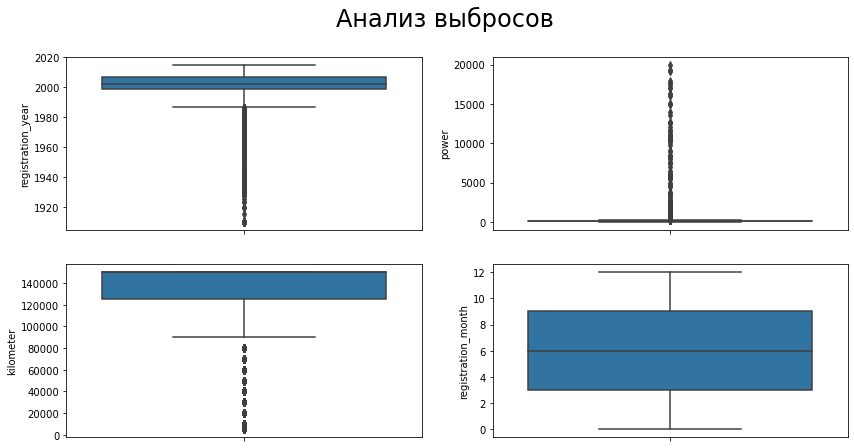

In [44]:
cols = ['registration_year', 'power', 'kilometer', 'registration_month']

fig, axs = plt.subplots(2, 2, figsize=(14, 7))
axs_lst = [
    axs[0, 0], axs[0, 1],
    axs[1, 0], axs[1, 1],
]

fig.suptitle('Анализ выбросов', fontsize=24)

for col, ax in zip(cols, axs_lst):
    sns_ax = sns.boxplot(data=df, y=col, ax=ax)

plt.show()

* Выбросы по году регистрации учитывать не стоит, поскольку модет на рнке есть и раритетные авто
* Выбросы по мощности следует удалить
* Выбросы пробегу выглядят подозрительно, но у нас нет дополнительной информации, поэтому оставляем

In [45]:
# Удалим наблюдения с аномальными значениями в столбце power

df = df[(df['power']>50) & (df['power']<1000)]

252.5


D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

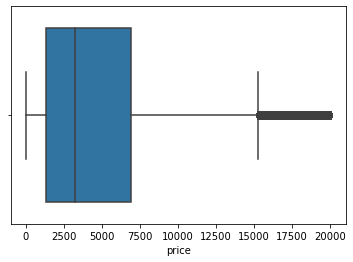

In [46]:
sns.boxplot(df['price'])

## 4. Подготовка данных к обучению

In [47]:
# Разбиваем выборку на тестовую и обучающую

cat_columns = ['vehicle_type', 
               'gearbox', 'model', 
               'fuel_type', 
               'brand', 
               'not_repaired', 
               'postal_code', 
               'registration_month']

df_labels = df.copy()
df_labels[cat_columns] = df_labels[cat_columns].astype('category')

enc = LabelEncoder()

for col in cat_columns:
    df_labels[col] = enc.fit_transform(df_labels[col])

x = df_labels.drop('price', axis=1)
y = df_labels['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)


In [48]:
def rmse(y, predictions):
    return mse(y, predictions)**0.5

rmse_score = make_scorer(rmse, greater_is_better=False)

## 5. Обучение моделей

In [51]:
rnd_st=12345
cv = KFold(n_splits=5, shuffle=True, random_state=rnd_st)

### 5.1 LGBMRegressor

In [52]:
estim = LGBMRegressor(boosting_type='gbdt', random_state=rnd_st)

params = {
    'n_estimators': [30, 60],
    'num_leaves': [20, 40, 60],
    'learning_rate': np.logspace(-2, 5),
}

grid_lgbm = GridSearchCV(estimator=estim, param_grid=params, cv=cv, scoring=rmse_score, n_jobs=-1)

In [53]:
%%time
grid_lgbm.fit(x_train, y_train)

Wall time: 9min 47s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': array([1.00000000e-02, 1.38949549e-02, 1.93069773e-02, 2.68269580e-02,
       3.72759372e-02, 5.17947468e-02, 7.19685673e-02, 1.00000000e-01,
       1.38949549e-01, 1.93069773e-01, 2.68269580e-01, 3.72759372e-01,
       5.17947468e-01,...
       3.72759372e+02, 5.17947468e+02, 7.19685673e+02, 1.00000000e+03,
       1.38949549e+03, 1.93069773e+03, 2.68269580e+03, 3.72759372e+03,
       5.17947468e+03, 7.19685673e+03, 1.00000000e+04, 1.38949549e+04,
       1.93069773e+04, 2.68269580e+04, 3.72759372e+04, 5.17947468e+04,
       7.19685673e+04, 1.00000000e+05]),
                         'n_estimators': [60, 150],
                         'num_leaves': [20, 40, 60]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [54]:
display(grid_lgbm.best_params_, grid_lgbm.best_score_)

{'learning_rate': 0.19306977288832497, 'n_estimators': 150, 'num_leaves': 60}

-1589.4857618460367

### 5.2 CatBoostRegressor

In [55]:
estim = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=rnd_st, cat_features = cat_columns)

params = {
    'n_estimators': [60, 150],
}

grid_cb = GridSearchCV(estimator=estim, param_grid=params, cv=cv, scoring=rmse_score, n_jobs=-1)

In [56]:
%%time
grid_cb.fit(x_train, y_train)

Wall time: 1min 11s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000002DCD39AF790>,
             n_jobs=-1, param_grid={'n_estimators': [60, 150]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [57]:
display(grid_cb.best_params_, grid_cb.best_score_)

{'n_estimators': 150}

-1635.2646204018845

### 5.3 Lasso

In [58]:
estim = Lasso(max_iter=15)

params = {
    'alpha': np.logspace(-2, 5)
}

grid_lasso = GridSearchCV(estimator=estim, param_grid=params, cv=cv, scoring=rmse_score, n_jobs=-1)

In [59]:
%%time
grid_lasso.fit(x_train, y_train)

Wall time: 31.3 s


D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 778531245364.302, tolerance: 429460218.55259436
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Lasso(max_iter=15), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.38949549e-02, 1.93069773e-02, 2.68269580e-02,
       3.72759372e-02, 5.17947468e-02, 7.19685673e-02, 1.00000000e-01,
       1.38949549e-01, 1.93069773e-01, 2.68269580e-01, 3.72759372e-01,
       5.17947468e-01, 7.19685673e-01, 1.000000...
       1.00000000e+02, 1.38949549e+02, 1.93069773e+02, 2.68269580e+02,
       3.72759372e+02, 5.17947468e+02, 7.19685673e+02, 1.00000000e+03,
       1.38949549e+03, 1.93069773e+03, 2.68269580e+03, 3.72759372e+03,
       5.17947468e+03, 7.19685673e+03, 1.00000000e+04, 1.38949549e+04,
       1.93069773e+04, 2.68269580e+04, 3.72759372e+04, 5.17947468e+04,
       7.19685673e+04, 1.00000000e+05])},
             scoring=make_scorer(rmse, greater_is_better=False))

In [60]:
display(grid_lasso.best_params_, grid_cb.best_score_)

{'alpha': 0.01}

-1635.2646204018845

## 6 Анализ моделей

In [61]:
models = [
    grid_lgbm.best_estimator_, 
    grid_cb.best_estimator_, 
    grid_lasso.best_estimator_
]

for model in models:
    start = time.time()
    model.fit(x_train, y_train)
    fit_time = time.time() - start
    pred = model.predict(x_test)
    pred_time = time.time() - start
    score = rmse(pred, y_test)
    print(f'{model}')
    print(f'Fit time: {fit_time:.2f}\nPredict time: {pred_time:.2f}\nScore: {score:.2f}')
    print()

LGBMRegressor(learning_rate=0.19306977288832497, n_estimators=150,
              num_leaves=60, random_state=12345)
Fit time: 1.12
Predict time: 1.31
Score: 1604.23

Fit time: 9.77
Predict time: 9.95
Score: 1658.83

Lasso(alpha=0.01, max_iter=15)
Fit time: 0.07
Predict time: 0.08
Score: 2837.38



D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 778531245364.302, tolerance: 429460218.55259436
  model = cd_fast.enet_coordinate_descent(


In [63]:
pred = models[0].predict(x_test)
score = rmse(pred, y_test)
if score < 2500:
    print(f'Модель {model} удовлетворяет критерию по качеству')
    print(f'Метрика выбранной модели {score:.2f}')
else:
    print(f'Модель {model} НЕ удовлетворяет критерию по качеству')
    print('Следует подобрать другую модель.')

Модель Lasso(alpha=0.01, max_iter=15) удовлетворяет критерию по качеству
Метрика выбранной модели 1604.23


## Выводы
* В рамках проект были построены три модели оценки рыночной цены автомобиля:
    - LGBMRegressor
    - CatBoostRegressor
    - Lasso (решил попробовать новую модель, поэтому ее выбрал)
* Наилучшей моделью с точки зрения метрики оказалась `LGBMRegressor`
* По времени оценивания лучшей стала модель `LGBMRegressor`
* Метрика RMSE 1604.23 < 2500